In [1]:
import earthpy.spatial as es
import numpy as np
import os, sys
import geopandas as gpd
import rasterio as rio
from shapely.geometry import box
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
target_dir = os.listdir("./data_cloud_imputing")
mb_raster_list = []
qa_raster_list = []

for folder in target_dir:
    stack = glob(
        os.path.join(
            os.getcwd(),
            "data_cloud_imputing",
            folder,
            "*STACKED.tif"
        )
    )
    
    mb_raster_list.append(stack)
    
for folder in target_dir:
    qa = glob(
        os.path.join(
            os.getcwd(),
            "data_cloud_imputing",
            folder,
            "*QA_PIXEL*.tif"
        )
    )
    
    qa_raster_list.append(qa)

mb_raster_list
qa_raster_list

[['C:\\Users\\tranq\\Documents\\Jupyter Root Folder\\Singapore NDVI\\data_cloud_imputing\\LC08_L2SP_125059_20220401_20220406_02_T1\\LC08_L2SP_125059_20220401_20220406_02_T1_QA_PIXEL_crop.TIF'],
 ['C:\\Users\\tranq\\Documents\\Jupyter Root Folder\\Singapore NDVI\\data_cloud_imputing\\LC08_L2SP_125059_20220417_20220420_02_T1\\LC08_L2SP_125059_20220417_20220420_02_T1_QA_PIXEL_crop.TIF'],
 ['C:\\Users\\tranq\\Documents\\Jupyter Root Folder\\Singapore NDVI\\data_cloud_imputing\\LC09_L2SP_125059_20220324_20230424_02_T1\\LC09_L2SP_125059_20220324_20230424_02_T1_QA_PIXEL_crop.TIF'],
 ['C:\\Users\\tranq\\Documents\\Jupyter Root Folder\\Singapore NDVI\\data_cloud_imputing\\LC09_L2SP_125059_20220628_20230409_02_T1\\LC09_L2SP_125059_20220628_20230409_02_T1_QA_PIXEL_crop.TIF']]

In [3]:
stacked_mb_raster = None

for mb_raster in mb_raster_list:
    with rio.open(mb_raster[0]) as src:
        stacked_bands = src.read()
        src.close()
    
    # Need to expand dimensions in preparation for np.vstack
    stacked_bands = np.expand_dims(stacked_bands, axis=0)
    # print(stacked_bands.shape)
    
    if stacked_mb_raster is None:
        stacked_mb_raster = stacked_bands
    else:
        # need to use vstack instead of stack, because stack expands the dims of the 
        # stacked_mb_raster, and thus they cannot be combined properly with stacked_bands later
        stacked_mb_raster = np.vstack((stacked_mb_raster, stacked_bands))
        
    # print(stacked_mb_raster.shape)

# works - now have 4 data cubes
stacked_mb_raster.shape

(4, 8, 1113, 1824)

In [4]:
# We now want to do the same thing with the QA bands
stacked_qa_raster = None

for qa_raster in qa_raster_list:
    with rio.open(qa_raster[0]) as src:
        # This reads the stacked_qa as a 1 x 1113 x 1824 raster
        stacked_qa = src.read()
        src.close()
    
    # We need to stack the qa mask 8 times - one for each band of the multiband raster
    stacked_qa = np.repeat(stacked_qa, 8, axis=0)
    
    # Need to expand dimensions in preparation for np.vstack
    stacked_qa = np.expand_dims(stacked_qa, axis=0)
    
    if stacked_qa_raster is None:
        stacked_qa_raster = stacked_qa
    else:
        # need to use vstack instead of stack, because stack expands the dims of the 
        # stacked_mb_raster, and thus they cannot be combined properly with stacked_bands later
        stacked_qa_raster = np.vstack((stacked_qa_raster, stacked_qa))

In [5]:
# Run a conservative cloud detection
def qa_pixel_interp_conservative(number):
    '''
    Helps interpret the 16bit data in the landsat qa pixels
    
    returns True if there is mid confidence cirrus, snow/ice, cloud shadow, OR clouds
    '''
    binary = bin(number)[2:].zfill(16)
    
    # if high confidence cirrus, snow/ice, cloud shadow, and clouds
    # 01 - low, 10 - medium, 11 - high
    if int(binary[:2]) > 10:
        return True
    elif int(binary[2:4]) > 10:
        return True
    elif int(binary[4:6]) > 10:
        return True
    elif int(binary[6:8]) > 10:
        return True
    else:
        return False
    
def apply_array_func(func, x):
    '''
    Applies a function element-wise across a 1D array
    '''
    return np.array([func(xi) for xi in x])

# classify the QA raster using conservative cloud estimates
unique_vals = np.unique(stacked_qa_raster)
masked_vals = apply_array_func(qa_pixel_interp_conservative, unique_vals)
masked_vals = unique_vals[masked_vals]
cl_mask_cons = np.isin(stacked_qa_raster, masked_vals)

cl_mask_cons.shape

(4, 8, 1113, 1824)

In [6]:
masked_mb_raster = np.ma.masked_array(stacked_mb_raster.astype(np.float32), cl_mask_cons)

# A masked 4D raster of 4 scenes
masked_mb_raster

masked_array(
  data=[[[[7748.0, 7808.0, 7699.0, ..., --, --, --],
          [7673.0, 7740.0, 7716.0, ..., --, --, --],
          [7768.0, 7872.0, 7719.0, ..., --, --, --],
          ...,
          [--, --, --, ..., 8018.0, 8202.0, 8396.0],
          [--, --, --, ..., 8261.0, 8318.0, 8295.0],
          [--, --, --, ..., 8661.0, 8393.0, 8310.0]],

         [[7982.0, 8043.0, 7986.0, ..., --, --, --],
          [7898.0, 7974.0, 7961.0, ..., --, --, --],
          [8042.0, 8140.0, 7942.0, ..., --, --, --],
          ...,
          [--, --, --, ..., 8324.0, 8632.0, 8818.0],
          [--, --, --, ..., 8562.0, 8671.0, 8583.0],
          [--, --, --, ..., 9090.0, 8674.0, 8536.0]],

         [[9263.0, 9357.0, 9390.0, ..., --, --, --],
          [9332.0, 9105.0, 9201.0, ..., --, --, --],
          [9302.0, 9537.0, 9447.0, ..., --, --, --],
          ...,
          [--, --, --, ..., 9468.0, 9865.0, 10358.0],
          [--, --, --, ..., 9725.0, 10114.0, 10078.0],
          [--, --, --, ..., 10410

In [7]:
# try to fill in the mask with lower layers

# The base scene is the first layer (2022-04-01)
base_scene = masked_mb_raster[0, ...]

for layer_num in range(masked_mb_raster.shape[0] - 1):
    # Takes the base scene and fills the missing with stuff from layer 2
    result = np.ma.filled(base_scene, 
                          # this fills missing data in layer 2 with nans
                          # if there is missing data in the same coord in both layers, then 
                          # then the result array will have a np.nan in that coord
                          np.ma.filled(masked_mb_raster[layer_num + 1, :], fill_value = np.nan)
                         )
    # turn result back into a masked array, where np.nan are the values to be masked.
    result_mask = np.isnan(result)
    
    # Rename it base_scene for the loop to work
    base_scene = np.ma.masked_array(result, result_mask)
    
# At the end, base_scene should be a single 8 x 1113 x 1824 raster
base_scene.shape

(8, 1113, 1824)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


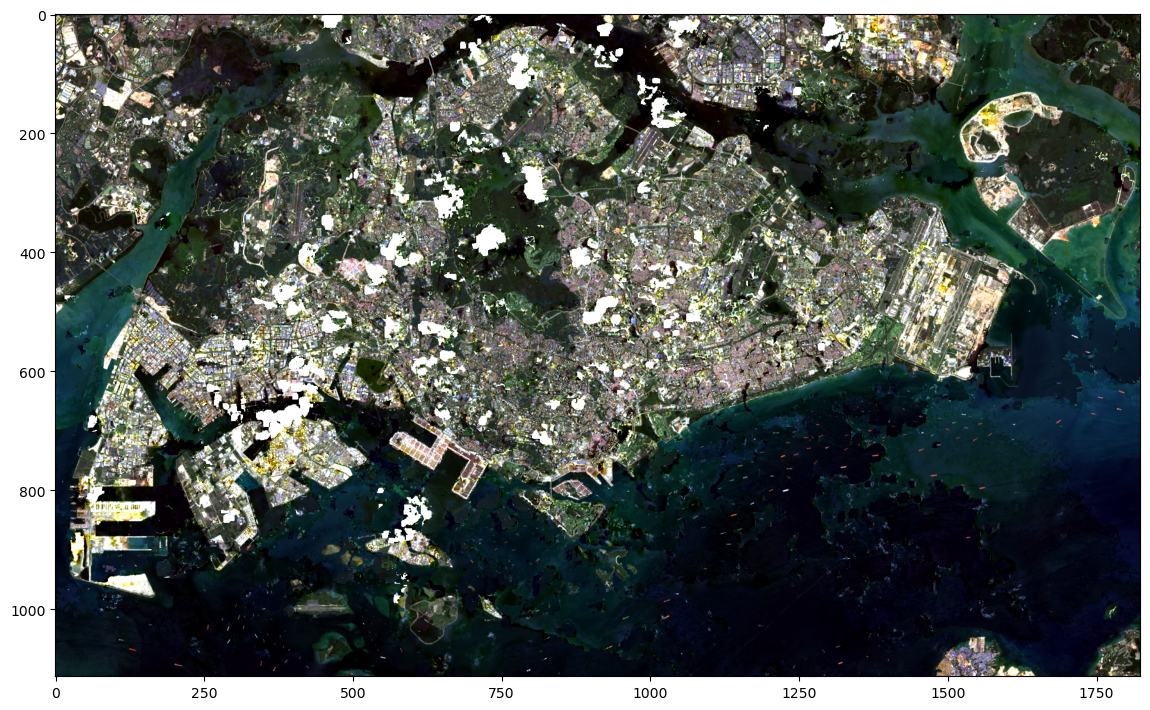

<Axes: >

In [41]:
### Check the result of base_scene using a TCC ###
from rasterio.plot import reshape_as_image

def histogram_stretch(img, min_vals = None, max_vals = 99):
    """
    Performs a histogram_stretch on an image. DO NOT use this for analytical workflows - 
    this should only be used to improve image visualization
    
    img: an unmasked 3D raster 
    
    min_vals: percentile that you wish to crop to
        will be np.zeros by default
    max_vals: percentile that you wish to crop to
        will be np.nanpercentile(img, 99) by default # crops to 99th percentile
    """
    if img.ndim != 3:
        print("ValueError: Your raster must have three dimensions.")
        return
    
    # This returns the max_valth percentile
    max_vals = np.nanpercentile(img, max_vals, axis = (1,2)).reshape(img.shape[0],1,1) 
    # min_vals = np.nanmin(tcc_toa, axis = (1,2)).reshape(3,1,1) # Use this to stretch to minimum values
    if min_vals is not None:
        min_vals = np.nanpercentile(img, min_vals, axis = (1,2)).reshape(img.shape[0],1,1)
    else:
        min_vals = np.zeros(img.shape[0]).reshape(img.shape[0],1,1)
    
    # Perform normalization
    img_stretched = (img - min_vals) / (max_vals - min_vals)
    
    # Clip values above 1
    img_stretched[img_stretched > 1] = 1
    
    return img_stretched

scaled_stack = base_scene * 0.0000275 - 0.2

# remember that histogram_stretch does not work with masked arrays
# scaled_stack = np.ma.filled(scaled_stack, fill_value = 0)
scaled_stack = np.ma.filled(scaled_stack, fill_value = 1)
# tcc = reshape_as_image(histogram_stretch(scaled_stack[[3,2,1], ...], min_vals = 10, max_vals = 90))
tcc = histogram_stretch(scaled_stack[[3,2,1], ...], min_vals = 5, max_vals = 95)

fig, ax = plt.subplots(figsize = (14,14))
# plt.imshow(reshape_as_image(scaled_stack[[3,2,1],...]))
# plt.imshow(tcc)
show(tcc)

<Axes: >

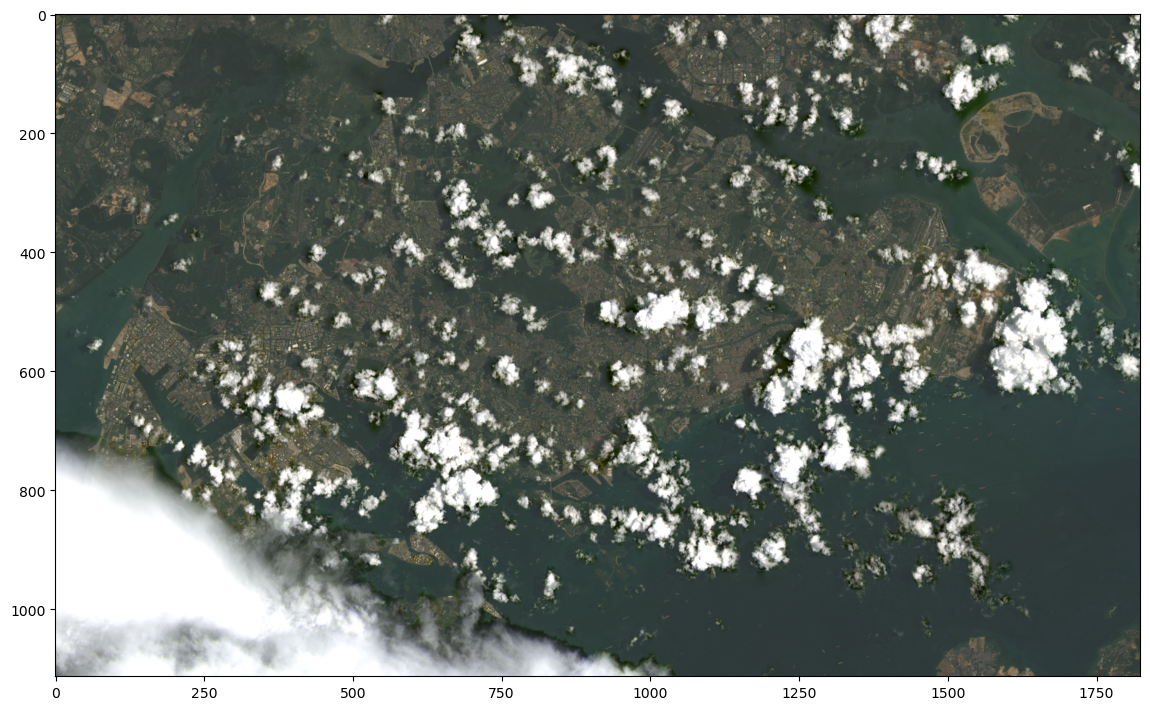

In [21]:
from rasterio.plot import show
with rio.open(glob("./data_cloud_imputing/*/LC08_L2SP_125059_20220401_20220406_02_T1_STACKED.tif")[0]) as src:
    original = src.read()
    src.close()

scaled = original * 0.0000275 - 0.2
original_tcc = histogram_stretch(scaled[[3,2,1], ...], min_vals = 0, max_vals = 95)

fig, ax = plt.subplots(figsize = (14,14))
show(original_tcc, ax = ax)

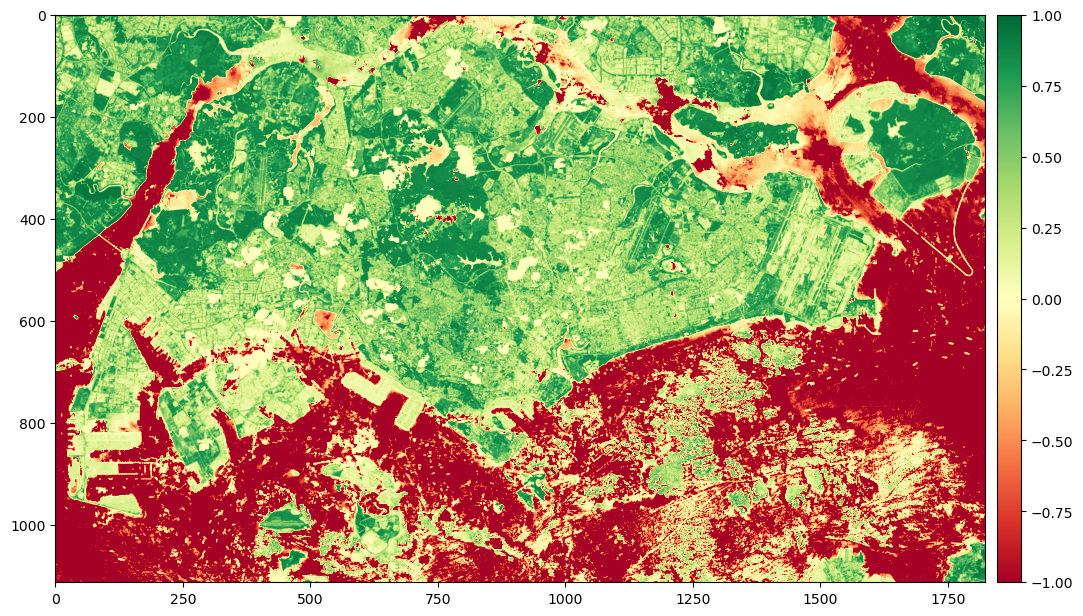

In [54]:
nir = scaled_stack[4,...]
red = scaled_stack[3,...]

ndvi = (nir - red) / (nir + red)
ndvi[(nir < 0) | (red < 0)] = -1

ndvi_masked = np.ma.masked_array(ndvi, mask = np.ma.getmask(base_scene[0,...]))

fig, ax = plt.subplots(figsize = (12,12))
im = plt.imshow(ndvi, cmap = "RdYlGn", vmin = -1, vmax = 1)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(im, cax = cax)

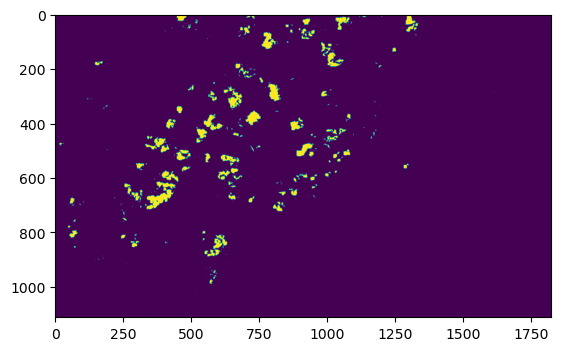

In [55]:
plt.imshow(np.ma.getmask(base_scene[0,...]))

In [59]:
# Get profile data from one raster
with rio.open(glob("./data_cloud_imputing/*/LC08_L2SP_125059_20220401_20220406_02_T1_STACKED.tif")[0]) as src:
    profile = src.profile
    src.close()
    
profile.update(nodata = np.nan, dtype = np.float32)

# Save the mosaicked image
with rio.open("./data_cloud_imputing/20220401_MOSAICKED_CROPPED_STACKED.tif",
              "w",
              **profile
             ) as dst:
    dst.write(base_scene)
    dst.close()
    


masked_array(
  data=[[[7748.0, 7808.0, 7699.0, ..., 7656.0, 7572.0, 7460.0],
         [7673.0, 7740.0, 7716.0, ..., 7701.0, 7538.0, 7375.0],
         [7768.0, 7872.0, 7719.0, ..., 7761.0, 7652.0, 7939.0],
         ...,
         [7790.0, 7736.0, 7673.0, ..., 8018.0, 8202.0, 8396.0],
         [7761.0, 7765.0, 7753.0, ..., 8261.0, 8318.0, 8295.0],
         [7707.0, 7688.0, 7715.0, ..., 8661.0, 8393.0, 8310.0]],

        [[7982.0, 8043.0, 7986.0, ..., 7831.0, 7796.0, 7662.0],
         [7898.0, 7974.0, 7961.0, ..., 7848.0, 7685.0, 7567.0],
         [8042.0, 8140.0, 7942.0, ..., 7948.0, 7836.0, 8104.0],
         ...,
         [8272.0, 8248.0, 8182.0, ..., 8324.0, 8632.0, 8818.0],
         [8273.0, 8272.0, 8263.0, ..., 8562.0, 8671.0, 8583.0],
         [8211.0, 8224.0, 8224.0, ..., 9090.0, 8674.0, 8536.0]],

        [[9263.0, 9357.0, 9390.0, ..., 8875.0, 8994.0, 8854.0],
         [9332.0, 9105.0, 9201.0, ..., 8818.0, 8855.0, 8737.0],
         [9302.0, 9537.0, 9447.0, ..., 8904.0, 8888.0, 917

(<Figure size 1200x1200 with 8 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

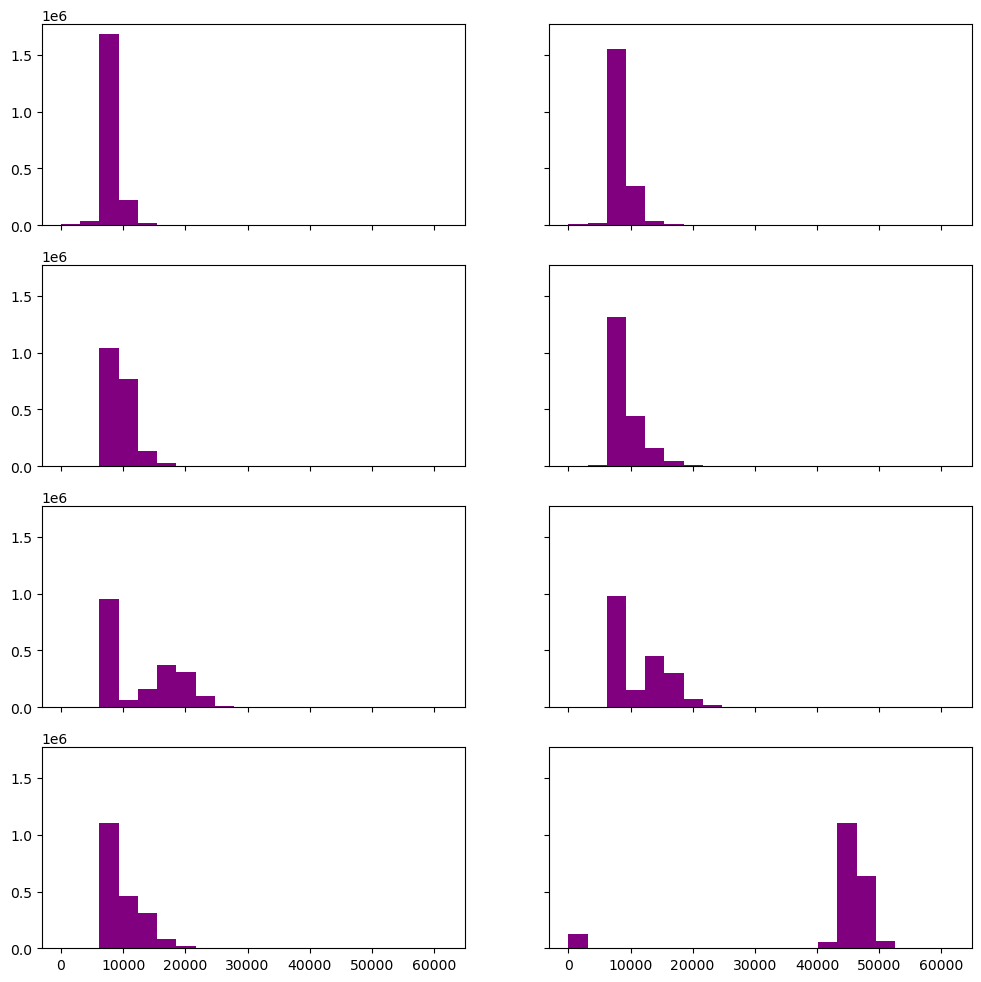

In [38]:
import earthpy.plot as ep
from rasterio.plot import reshape_as_raster
ep.hist(base_scene)

(<Figure size 1200x1200 with 8 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

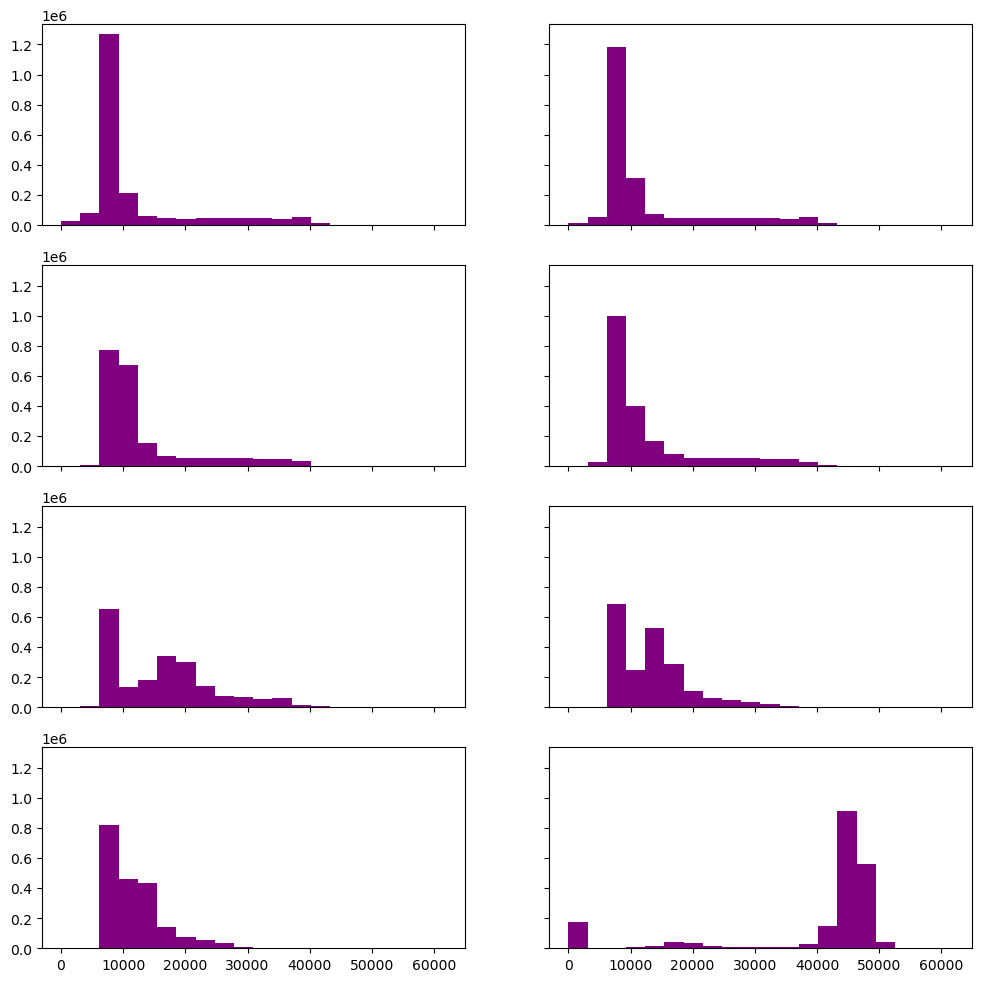

In [37]:
ep.hist(original)